In [17]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import datetime
import torch
import torch.nn as nn
import torch.optim as optim

## Load Data

In [2]:
original_dataset = pd.read_csv('nvidia.csv')
original_dataset.head(5)

,Date,Close/Last,Volume,Open,High,Low
0,11/21/2024,$146.67,400946600,$149.35,$152.89,$140.70
1,11/20/2024,$145.89,309871700,$147.41,$147.56,$142.73
2,11/19/2024,$147.01,227834900,$141.32,$147.13,$140.99
3,11/18/2024,$140.15,221866000,$139.50,$141.55,$137.15
4,11/15/2024,$141.98,250132900,$144.87,$145.24,$140.08


### Change date string to date object

In [3]:
def str_to_date(date_str):
    split = date_str.split('/')
    month, day, year = int(split[0]), int(split[1]), int(split[2])
    return datetime.date(year, month, day)

In [4]:
original_dataset['Date'] = original_dataset['Date'].apply(str_to_date)

### Change money string to float

In [5]:
def str_to_float(price_str):
    price_str = price_str.replace('$', '')
    return float(price_str)

In [6]:
original_dataset['Close/Last'] = original_dataset['Close/Last'].apply(str_to_float)

### Get data only with date and close price

In [7]:
dataset_with_close = original_dataset[['Date','Close/Last']]
dataset_with_close.tail(5)

,Date,Close/Last
2511,2014-12-01,0.5145
2512,2014-11-28,0.5242
2513,2014-11-26,0.5229
2514,2014-11-25,0.5142
2515,2014-11-24,0.5145


### Plot the data

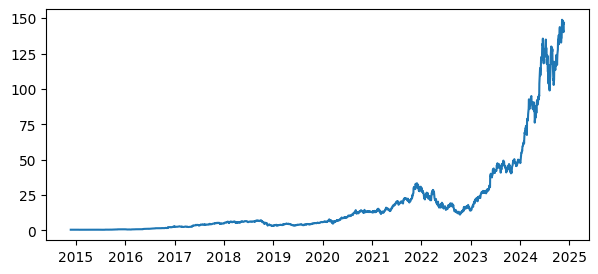

In [8]:
plt.figure(figsize=(7, 3))
plt.plot(original_dataset['Date'],original_dataset['Close/Last'])

In [9]:
def context_window(dataset, block_size):
    new_dataset = pd.DataFrame(columns=['target_date', 'target_value'] + [f'prev_{i}' for i in range(1,block_size+1)])
    span = len(dataset) - block_size
    for i in range(span):
        target_date = dataset.iloc[i]['Date']
        target_value = dataset.iloc[i]['Close/Last']
        window_data = [dataset.iloc[i+j]['Close/Last'] for j in range(1,block_size+1)]
        new_dataset.loc[i] = [target_date, target_value] + window_data
    return new_dataset

In [10]:
block_size = 5
new_dataset = context_window(dataset_with_close, block_size)
new_dataset.tail(5)

,target_date,target_value,prev_1,prev_2,prev_3,prev_4,prev_5
2506,2014-12-08,0.5200,0.5268,0.5238,0.5285,0.5152,0.5145
2507,2014-12-05,0.5268,0.5238,0.5285,0.5152,0.5145,0.5242
2508,2014-12-04,0.5238,0.5285,0.5152,0.5145,0.5242,0.5229
2509,2014-12-03,0.5285,0.5152,0.5145,0.5242,0.5229,0.5142
2510,2014-12-02,0.5152,0.5145,0.5242,0.5229,0.5142,0.5145


In [25]:
def get_dataset(original_dataset, block_size):
    np_dataset = original_dataset.to_numpy()
    dates = np_dataset[:,0]
    X = np_dataset[:,2:].reshape(-1,block_size, 1)
    Y = np_dataset[:,1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

In [26]:
dates, X, Y = get_dataset(new_dataset, block_size)
dates.shape, X.shape, Y.shape

((2511,), (2511, 5, 1), (2511,))

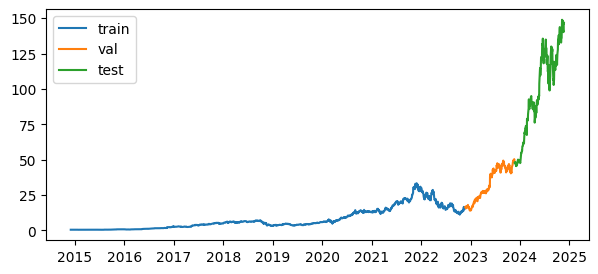

In [27]:
n_90 = int(len(dates)*0.1)
n_80 = int(len(dates)*0.2)
dates_train, X_train, Y_train = dates[n_80:], X[n_80:], Y[n_80:]
dates_val, X_val, Y_val = dates[n_90:n_80], X[n_90:n_80], Y[n_90:n_80]
dates_test, X_test, Y_test = dates[:n_90], X[:n_90], Y[:n_90]

plt.figure(figsize=(7, 3))
plt.plot(dates_train,Y_train)
plt.plot(dates_val,Y_val)
plt.plot(dates_test,Y_test)
plt.legend(['train', 'val', 'test'])
plt.show()

In [32]:
class LSTMModel(nn.Module):
    def __init__(self,input_size=block_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        
        # Take the last time step
        x = lstm_out[:, -1, :]
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x


In [35]:
# Model initialization
model = LSTMModel()

# Loss and Optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Training loop (replace with your actual training code)
def train(model, X_train, y_train, X_val, y_val, epochs=100):
    for epoch in range(epochs):
        # Convert numpy arrays to PyTorch tensors if needed
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train_tensor)
        
        # Compute loss
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Optional: Validation and logging
        if epoch % 10 == 0:
            with torch.no_grad():
                val_outputs = model(torch.FloatTensor(X_val))
                val_loss = criterion(val_outputs, torch.FloatTensor(y_val))
                print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

# Example usage
train(model, X_train, Y_train, X_val, Y_val)

/datas/store163/othsueh/miniconda3/envs/money/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([2009])) that is different to the input size (torch.Size([2009, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/datas/store163/othsueh/miniconda3/envs/money/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([251])) that is different to the input size (torch.Size([251, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/100], Training Loss: 114.9650, Validation Loss: 1234.6338
Epoch [11/100], Training Loss: 112.2199, Validation Loss: 1218.8375
Epoch [21/100], Training Loss: 107.6510, Validation Loss: 1193.3774
Epoch [31/100], Training Loss: 96.0208, Validation Loss: 1129.2172
Epoch [41/100], Training Loss: 72.1184, Validation Loss: 984.0389
Epoch [51/100], Training Loss: 56.9524, Validation Loss: 764.7236
Epoch [61/100], Training Loss: 57.3993, Validation Loss: 763.3524
Epoch [71/100], Training Loss: 56.3921, Validation Loss: 831.8947
Epoch [81/100], Training Loss: 56.2605, Validation Loss: 820.5560
Epoch [91/100], Training Loss: 56.1479, Validation Loss: 796.2929
